<a href="https://colab.research.google.com/github/EyalMK/IntroductionToCloudProgramming-Tutorials/blob/main/Tutorial6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
### Imports
import json
import requests
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from firebase import firebase
from matplotlib import pyplot as plt

In [82]:
class Utilities:
  def __init__(self):
    self.chosen_words = ['sketch', 'drawing', 'assembly', 'linear', 'point', 'feature', 'appearance', 'dimension', 'simulation', 'context']

  def get_chosen_words(self):
    return self.chosen_words

  def display_indices_graph(self, data):
    # Assuming 'data' is a JSON string, parse it to a dictionary
    if isinstance(data, str):
        indices = json.loads(data)
    elif isinstance(data, dict):
        indices = data
    else:
        raise TypeError("Data must be a JSON string or a dictionary.")

    # Combine all nested dictionaries and sum their values
    combined_indices = {}
    for key in data:
        nested_dict = json.loads(data[key])
        for word, count_dict in nested_dict.items():
            for subword, count in count_dict.items():
                if subword in combined_indices:
                    combined_indices[subword] += count
                else:
                    combined_indices[subword] = count

    # Sort the dictionary by ascending number of occurrences
    sorted_indices = dict(sorted(combined_indices.items(), key=lambda item: item[1]))

    print('Read data: ', sorted_indices)

    # Plot the sorted data
    plt.figure(figsize=(10, 5))
    plt.bar(sorted_indices.keys(), sorted_indices.values())
    plt.xlabel('Words')
    plt.ylabel('Occurrences')
    plt.title('Word Occurrences in Ascending Order')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [83]:
class Scraper:
  def __init__(self, chosen_words, url, query):
    self.indices = {}
    self.chosen_words = chosen_words
    self.url = url
    self.query = query

  def index_words(self, soup):
      words = re.findall(r'\w+', soup.get_text())
      for word in words:
          word = word.lower()
          if word in self.indices:
              self.indices[word] += 1
          else:
              self.indices[word] = 1
      return self.indices

  def remove_stop_words(self):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at'}
    for stop_word in stop_words:
        if stop_word in self.indices:
            del self.indices[stop_word]

  def fetch_page(self, url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        return None

  def search(self, query, indices):
    stemmer = PorterStemmer()
    query_words = re.findall(r'\w+', query.lower())
    print(query)
    results = {}
    for word in query_words:
        word = stemmer.stem(word)
        if word in indices:
            results[word] = indices[word]
    self.indices = results
    return results


  def apply_stemming(self):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in self.indices.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index


  def search_engine(self):
    soup = self.fetch_page(self.url)
    if soup is None:
        return None
    self.index_words(soup)
    self.remove_stop_words()
    stemmed_indices = self.apply_stemming()
    results = self.search(self.query, stemmed_indices)
    return results


In [84]:
class DatabaseHandler:
  def __init__(self, firebase_url, utils):
    self.db_url = firebase_url
    self.firebase = None
    self.connect_to_firebase()
    self.utils = utils

  def connect_to_firebase(self):
    self.firebase = firebase.FirebaseApplication(self.db_url, None)

  def validate_connection(self):
    if self.firebase is None:
      print("Error connecting to database")
      return False
    return True


  def read_from_database(self):
    if not self.validate_connection():
      return

    data = self.firebase.get('/indices', None)
    if data is None:
      print("No indices found")
    else:
      self.utils.display_indices_graph(data)

  def write_to_database(self, data):
    if not self.validate_connection():
      return
    self.firebase.post('/indices', data)
    print("Data written to database")



In [85]:
from os import write
class App:
  def __init__(self, firebase_url, web_url):
    self.indices = {}
    self.utils = Utilities()
    self.chosen_words = self.utils.get_chosen_words()
    self.db_handler = DatabaseHandler(firebase_url, self.utils)
    self.web_url = web_url

  def run(self):
    for i in range(len(self.chosen_words)):
      scraper = Scraper(self.chosen_words, self.web_url, self.chosen_words[i])
      results = scraper.search_engine()
      if results is not None:
        self.indices[self.chosen_words[i]] = results
    write_data = json.dumps(self.indices)
    self.db_handler.write_to_database(write_data)
    self.db_handler.read_from_database()


sketch
drawing
assembly
linear
point
feature
appearance
dimension
simulation
context
Data written to database
Read data:  {'linear': 42, 'dimens': 147, 'point': 222, 'appear': 228, 'featur': 354, 'simul': 447, 'sketch': 660, 'draw': 678, 'assembl': 837, 'context': 2028}


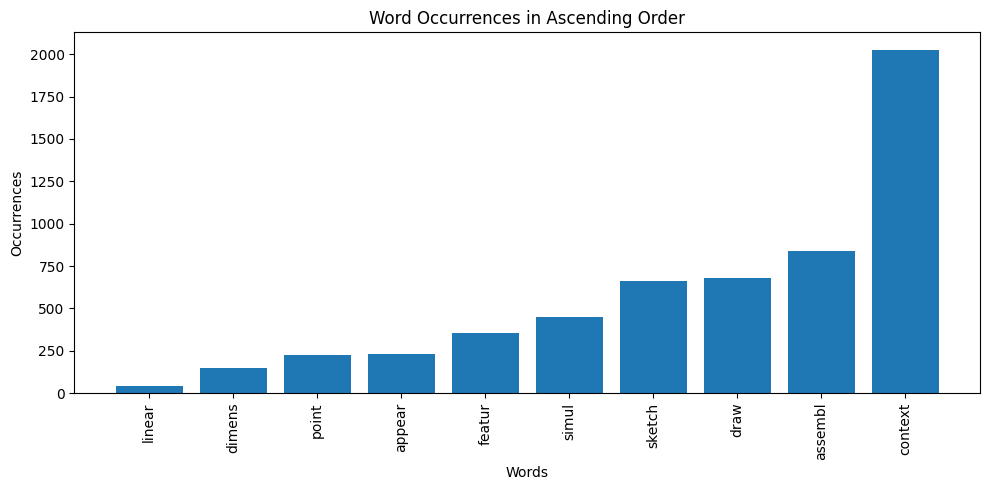

In [86]:
### Main Instance
if __name__ == '__main__':
  firebase_url = "https://cloud-tutorial-5-default-rtdb.europe-west1.firebasedatabase.app/"
  web_url = 'https://cad.onshape.com/help/Content/Glossary/glossary.htm?tocpath=_____19'
  app = App(firebase_url, web_url)
  app.run()